<a href="https://colab.research.google.com/github/Tobsam237/Project_capstone3/blob/main/04_Preprocessing_Capstone3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Capstone Three: Preprocessing and Data Development**

In [41]:
#import necessary packages and load data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

data = files.upload()

Saving df_wrangled3.csv to df_wrangled3 (1).csv


In [42]:
df = pd.read_csv('df_wrangled3.csv', index_col=0)
df.head()

,FileName,Date,SegFile,b,e,LBE,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,A,B,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,0.0,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,0.0,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,0.0,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,0.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0005.txt,533.0,1147.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,0.0,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


* Let's confirm our data is clean and ready for preprocessing 
* Also observe our data has varying scales, thus, we need to standardize


In [43]:
#drop unnecessary columns
df.drop(labels=['FileName', 'Date', 'SegFile'], axis=1, inplace=True)

In [44]:
#check for null values by feature
df.isna().sum()

b           0
e           0
LBE         0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
A           0
B           0
C           0
D           0
E           0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64

In [45]:
#Let's see each number of distinct values by columns
df.nunique()

b            979
e           1064
LBE           48
AC            22
FM            96
UC            19
ASTV          75
MSTV          57
ALTV          87
MLTV         249
DL            15
DS             2
DP             5
Width        154
Min          109
Max           86
Nmax          18
Nzeros         9
Mode          88
Mean         103
Median        95
Variance     133
Tendency       3
A              2
B              2
C              2
D              2
E              2
AD             2
DE             2
LD             2
FS             2
SUSP           2
CLASS         10
NSP            3
dtype: int64

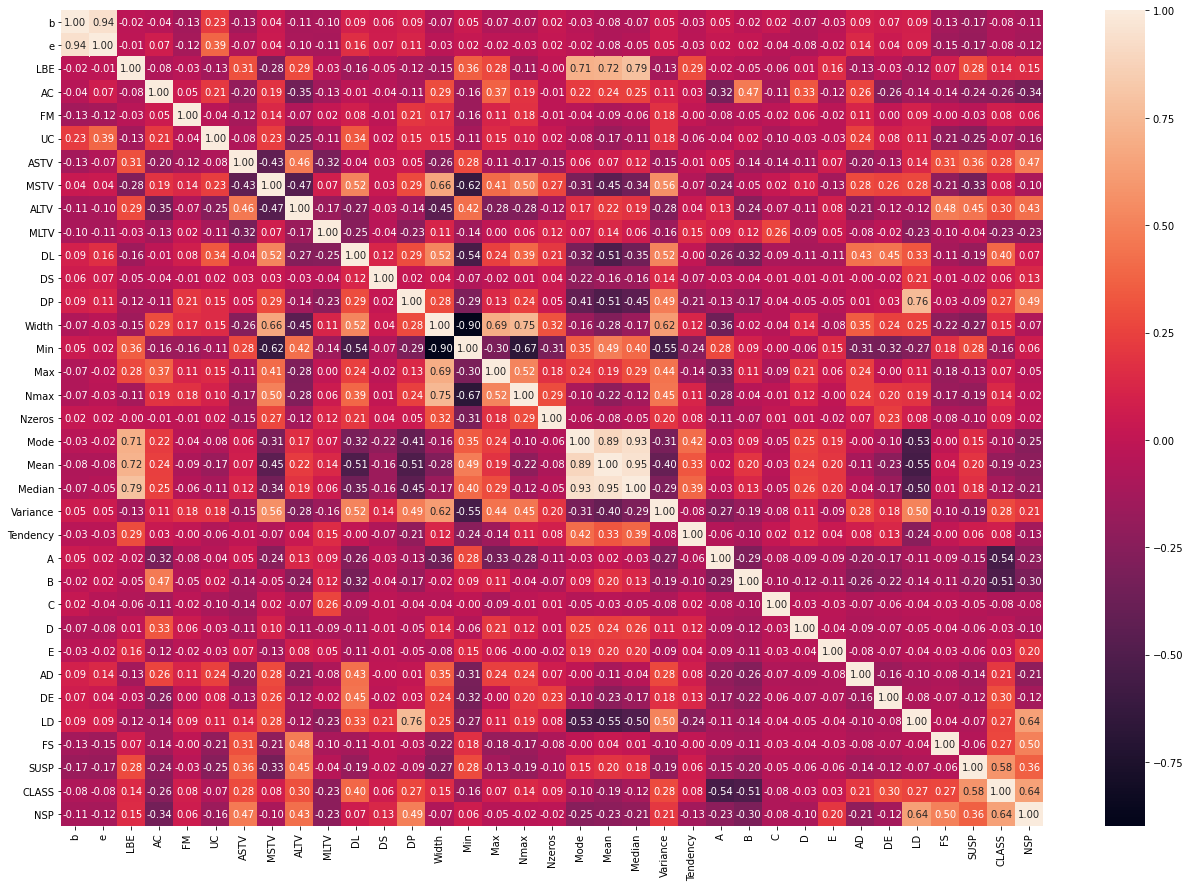

In [46]:
#Lets check for colinearity using seaborn's heatmap
plt.figure(figsize=(22,15))
sns.heatmap(df.corr(), annot= True, fmt='.2f')

**Observe from the heatmap above**
* Multiple features are colinear with eachother
* Some features are correlated with our target variable NSP
* Some features are heavily correlerated with other features

Foremost, let's split our dataset to its dependent and independent features

In [47]:
#Let us select our independent and target variables
X = df.iloc[:,:].drop(['CLASS','NSP', 'LD'], axis=1)
y = df.NSP
print(' X shape: ', X.shape, '\n', 'y shape: ', y.shape)

 X shape:  (2126, 32) 
 y shape:  (2126,)


##**Standardize data**

To scale our independent features, we need to distinguish between the numerical and categorical features.
Thus, after careful observation of datset, we chose a threshold of 10 for distinct values of each features to determine classified features of independent features

In [48]:
#Let's distinguish categorical from numerical fetaures

cat_features = []
num_features = []
for i in X.columns:
  if X[i].nunique() <= 10:
    cat_features.append(i)
  else:
    num_features.append(i)

print(cat_features)
print(num_features)

#df[df.columns[cat_features]]


['DS', 'DP', 'Nzeros', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'FS', 'SUSP']
['b', 'e', 'LBE', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'Width', 'Min', 'Max', 'Nmax', 'Mode', 'Mean', 'Median', 'Variance']


In [49]:
#make a dataframe for each group
X_cat = X[cat_features]
X_num = X[num_features]
X_num.head(3)

,b,e,LBE,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,Width,Min,Max,Nmax,Mode,Mean,Median,Variance
0,240.0,357.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,64.0,62.0,126.0,2.0,120.0,137.0,121.0,73.0
1,5.0,632.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,130.0,68.0,198.0,6.0,141.0,136.0,140.0,12.0
2,177.0,779.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,130.0,68.0,198.0,5.0,141.0,135.0,138.0,13.0


In [50]:
#Let's scale our numerical data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_num = scaler.fit_transform(X_num)

In [51]:
#concat the categorical X_features with the standardized X
X_num = pd.DataFrame(scaled_X_num, columns= X_num.columns)

X_scaled = pd.concat([X_num, X_cat], axis=1)

##**Let's deal with Multcolinearity**

Observe from initial heatmap, that multicolinearity exist among features and with target the target variable. Let's according reduce multicolinearity using *collinearity* library.

In [52]:
#!pip install collinearity

In [53]:
#import collinearity library and fit to independent features 
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_regression
selector = SelectNonCollinear(correlation_threshold = 0.4, scoring=f_regression)
selector.fit(X_scaled.values,y)

In [54]:
#Mask results to obtain new independent variable
mask = selector.get_support()
X2 = X_scaled.loc[:,mask]

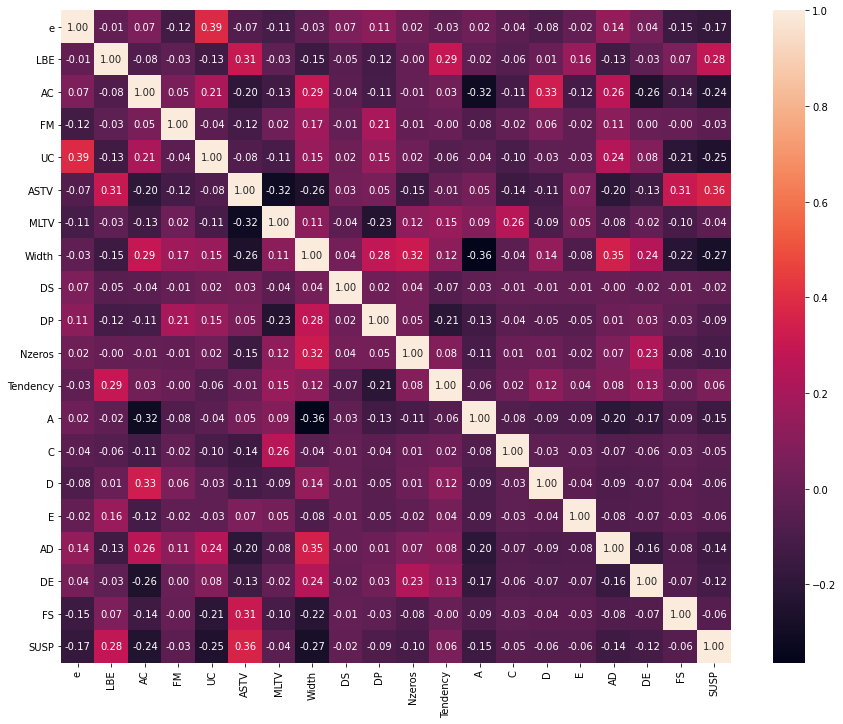

In [55]:
#let's confirm X2 has low collinearity
plt.figure(figsize=(15,12))
sns.heatmap(X2.corr(), annot=True, fmt='.2f')

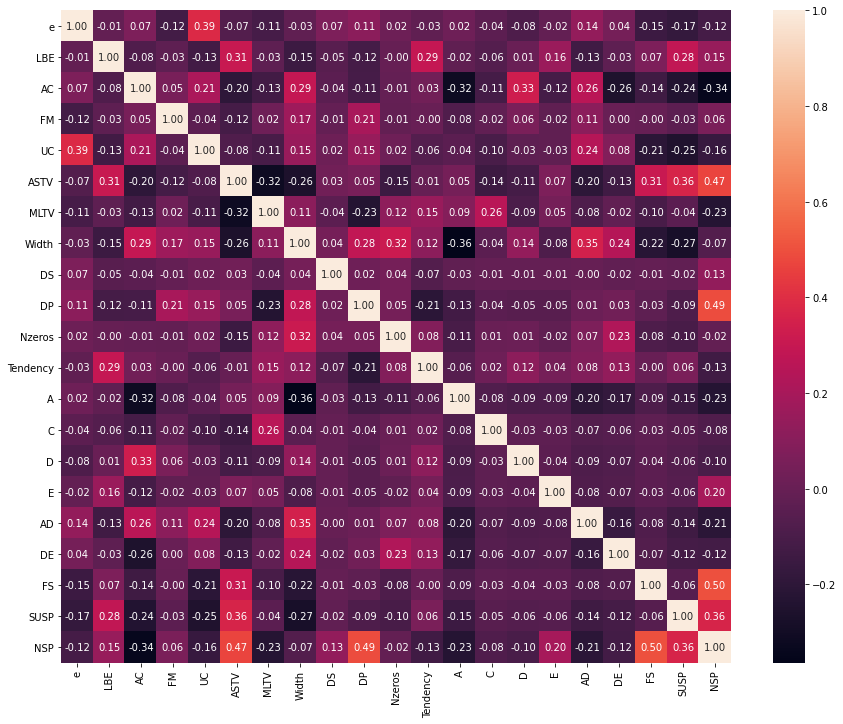

In [56]:
#let's double check feature colinearity with our target variable
with_target = X2.assign(NSP = y)
plt.figure(figsize=(15,12))
sns.heatmap(with_target.corr(), annot=True, fmt='.2f')


In [57]:
#observe that ASTV, DP and FS still has high collinearity with NSP, 
#thus we drop

X2 = X2.drop(['ASTV', 'DP', 'FS'], axis=1)


**Thus far, we have been able to:**
* Standardise our data

* Reduce and remove multicollinearity among features

**Next, let's observe how our data performs on some models**

In [58]:
#import split tools, models and metrics of validation from sklearn library
#We stratify target variable to collect uniform feature across classes 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X2, y, stratify=y, test_size=0.3, random_state=42)

In [59]:
#LogisticRegression
logmod = LogisticRegression()
logmod.fit(X_train, y_train)
logmod_pred = logmod.predict(X_test)

#evaluate
print(confusion_matrix(y_test, logmod_pred))
print('F1 score: ',f1_score(y_test, logmod_pred, average='weighted'))
print('Accuracy is: ', accuracy_score(y_test, logmod_pred))
print('Recall is: ', recall_score(y_test, logmod_pred, average='weighted'))

[[496   0   1]
 [ 11  76   1]
 [  2   0  51]]
F1 score:  0.975931778394546
Accuracy is:  0.9764890282131662
Recall is:  0.9764890282131662


In [60]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rfmod = RandomForestClassifier()
rfmod.fit(X_train, y_train)
rfmod_pred = rfmod.predict(X_test)

#evaluate
print(confusion_matrix(y_test, rfmod_pred))
print('F1 score: ',f1_score(y_test, rfmod_pred, average='weighted'))
print('Accuracy is: ', accuracy_score(y_test, rfmod_pred))
print('Recall is: ', recall_score(y_test, rfmod_pred, average='weighted'))
print('Training Socre: ',rfmod.score(X_train, y_train))
print('Test Socre: ',rfmod.score(X_test, y_test))

[[495   1   1]
 [ 11  77   0]
 [  0   0  53]]
F1 score:  0.979156037835406
Accuracy is:  0.9796238244514106
Recall is:  0.9796238244514106
Training Socre:  1.0
Test Socre:  0.9796238244514106


Observe our data performed quite well but with a tendency to overfit. We could make it better by weighing the effect and importance of each independent feature



In [61]:
rfmod.feature_importances_

array([0.03967034, 0.05071963, 0.10869864, 0.02615092, 0.047418  ,
       0.09528639, 0.09374655, 0.00318991, 0.00854964, 0.02512098,
       0.07067255, 0.01078294, 0.00175482, 0.10179954, 0.00998387,
       0.04889775, 0.25755751])

##**Feature Selection**
Observe from the above that some features importance to our model is so insignificant. Therefore let's perform a feature selection procedure to leave out negligible features.

**Benefits of feature selection are:**
* **Reduces Overfitting:** Less redundant data means less opportinity to make decision based on noise
* **Reduced Machine Time:** Less data means algorithm trains faster 

**Unvariate Feature Selection:** SelectKBest


In [62]:
X_train.shape

(1488, 17)

In [63]:
#Import necessary libaries
from sklearn.feature_selection import SelectKBest, chi2, f_regression

kbest = SelectKBest(f_regression, k=14).fit(X_train, y_train)

In [64]:
#Rank features importances by thier score
selected_features_df = pd.DataFrame({'Feature':list(X2.columns),
                                     'Scores':kbest.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
16,SUSP,242.366532
2,AC,191.741055
10,A,81.692933
5,MLTV,76.813624
14,AD,67.099501
13,E,58.955572
4,UC,40.228658
9,Tendency,38.745541
7,DS,31.178942
15,DE,26.284907


In [65]:
#update independent features: X_train, X_test with transformed X
X_train_freg = kbest.transform(X_train)
X_test_freg = kbest.transform(X_test)

Let's attempt and observe result of our updated independent variables on models

In [66]:
#LogisticRegression
logmod = LogisticRegression()
logmod.fit(X_train_freg, y_train)
logmod_pred = logmod.predict(X_test_freg)

#evaluate
print(confusion_matrix(y_test, logmod_pred))
print('F1 score: ',f1_score(y_test, logmod_pred, average='weighted'))
print('Accuracy is: ', accuracy_score(y_test, logmod_pred))
print('Recall is: ', recall_score(y_test, logmod_pred, average='weighted'))

[[495   0   2]
 [ 13  74   1]
 [  3   0  50]]
F1 score:  0.9694671813924687
Accuracy is:  0.9702194357366771
Recall is:  0.9702194357366771


In [67]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rfmod = RandomForestClassifier()
rfmod.fit(X_train_freg, y_train)
rfmod_pred = rfmod.predict(X_test_freg)

#evaluate
print(confusion_matrix(y_test, rfmod_pred))
print('F1 score: ',f1_score(y_test, rfmod_pred, average='weighted'))
print('Accuracy is: ', accuracy_score(y_test, rfmod_pred))
print('Recall is: ', recall_score(y_test, rfmod_pred, average='weighted'))
print('Training Socre: ',rfmod.score(X_train_freg, y_train))
print('Test Socre: ',rfmod.score(X_test_freg, y_test))

[[495   1   1]
 [ 11  77   0]
 [  2   0  51]]
F1 score:  0.9760287743805965
Accuracy is:  0.9764890282131662
Recall is:  0.9764890282131662
Training Socre:  1.0
Test Socre:  0.9764890282131662


##**Recursive Feature Elimination with cross validation (RFECV)**

Let's attempt a  feature selection procedure that fits a model and removes the weakest feature (or features) until the specified number of features is reached. 



In [68]:
from sklearn.feature_selection import RFECV

logreg = LogisticRegression()
rfecv = RFECV(estimator=logreg, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 16
Best features : Index(['e', 'LBE', 'AC', 'FM', 'UC', 'MLTV', 'Width', 'DS', 'Tendency', 'A',
       'C', 'D', 'E', 'AD', 'DE', 'SUSP'],
      dtype='object')


In [69]:
rfecv.grid_scores_

array([0.87432264, 0.90456918, 0.90456918, 0.90389804, 0.95025874,
       0.96773778, 0.9663955 , 0.97110026, 0.97244481, 0.97311595,
       0.97244029, 0.97244255, 0.97311369, 0.97311369, 0.97445597,
       0.97445823, 0.97445823])

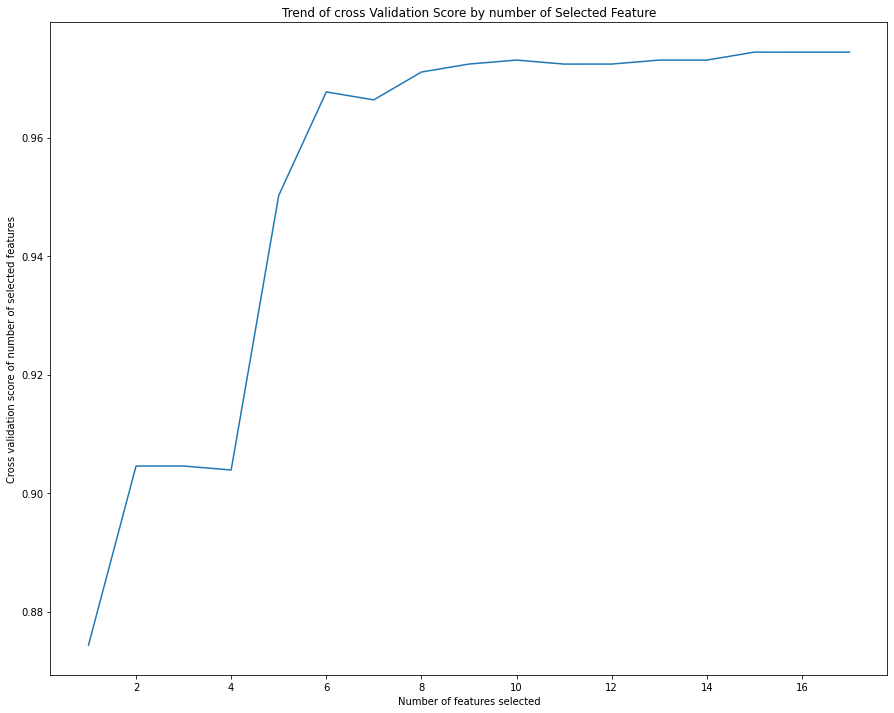

In [70]:
#plt cross validation score trend by number of selected features
plt.figure(figsize=(15,12))
plt.title('Trend of cross Validation Score by number of Selected Feature')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Observe from the above
* The mininum number of features for optimum results is 16
* Our model learning rate drops critically after 9 features 

In [71]:
#Update independent features; X_train, X_test
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)

In [72]:
#LogisticRegression
logmod = LogisticRegression()
logmod.fit(X_train_rfecv, y_train)
logmod_pred = logmod.predict(X_test_rfecv)
print(confusion_matrix(y_test, logmod_pred))
print('F1 score: ',f1_score(y_test, logmod_pred, average='weighted'))
print('Accuracy is: ', accuracy_score(y_test, logmod_pred))
print('Recall is: ', recall_score(y_test, logmod_pred, average='weighted'))

[[496   0   1]
 [ 12  75   1]
 [  2   0  51]]
F1 score:  0.9742608422199287
Accuracy is:  0.9749216300940439
Recall is:  0.9749216300940439


##Summary

We have been able to prepare our data for modelling:
* Standardizing using StandardScaler
* We succesfully reduced multicolinearity to it's bearest minimum
* We also feature selected the optimum number to obtain the best scores using rfecv

In [73]:
#Let's save our data for modelling stage

Xf = X2[X_train.columns[rfecv.support_]]
dff = Xf.assign(NSP=y.values)

#download
#dff.to_csv('df_final.csv')
#files.download('df_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>